Train shape: (20631, 27)
Test shape: (13096, 26)
Train sample:


,unit_number,time_in_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,...,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,RUL
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.205882,0.199608,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.279412,0.162813,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.220588,0.171793,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.294118,0.174889,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,188
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.235294,0.174734,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,187


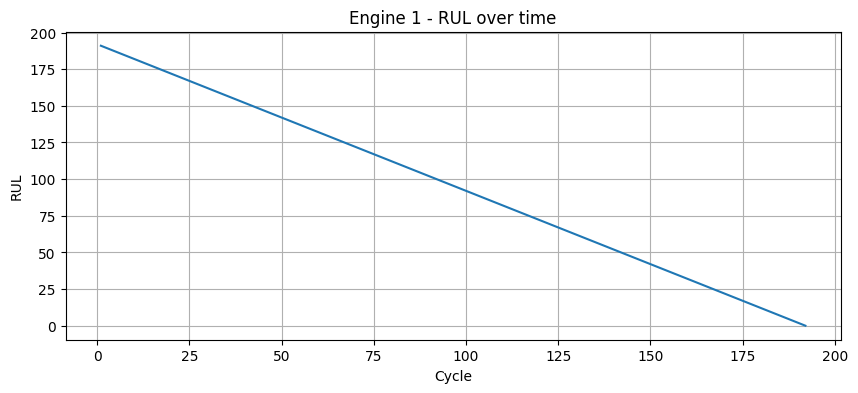

In [1]:
# --- IMPORTS ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# --- CONFIG ---
FD = "FD001"
COLUMNS = ['unit_number', 'time_in_cycles'] + \
          [f'op_setting_{i}' for i in range(1, 4)] + \
          [f'sensor_measurement_{i}' for i in range(1, 22)]

# --- LOAD DATA ---
train_df = pd.read_csv(f'train_{FD}.txt', sep=' ', header=None)
test_df = pd.read_csv(f'test_{FD}.txt', sep=' ', header=None)
rul_df = pd.read_csv(f'RUL_{FD}.txt', sep=' ', header=None)

# Clean extra columns (from trailing spaces)
train_df.drop(columns=train_df.columns[train_df.isna().all()], inplace=True)
test_df.drop(columns=test_df.columns[test_df.isna().all()], inplace=True)

# Assign column names
train_df.columns = COLUMNS
test_df.columns = COLUMNS

# --- RUL for TRAIN ---
train_df['RUL'] = train_df.groupby('unit_number')['time_in_cycles'].transform('max') - train_df['time_in_cycles']

# --- RUL for TEST ---
# Get last cycle per engine
test_last = test_df.groupby('unit_number').last().reset_index()
# Attach ground truth RULs
test_last['RUL'] = rul_df[0].values

# --- NORMALIZE ---
feature_cols = train_df.columns[2:-1]  # Exclude ID, cycle, and RUL
scaler = MinMaxScaler()
train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])
test_df[feature_cols] = scaler.transform(test_df[feature_cols])

# --- PREVIEW ---
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print("Train sample:")
display(train_df.head())

# --PLOT ---
# Plot RUL progression of one engine
example_id = 1
plt.figure(figsize=(10, 4))
plt.plot(train_df[train_df['unit_number'] == example_id]['time_in_cycles'],
         train_df[train_df['unit_number'] == example_id]['RUL'])
plt.title(f'Engine {example_id} - RUL over time')
plt.xlabel('Cycle')
plt.ylabel('RUL')
plt.grid()
plt.show()


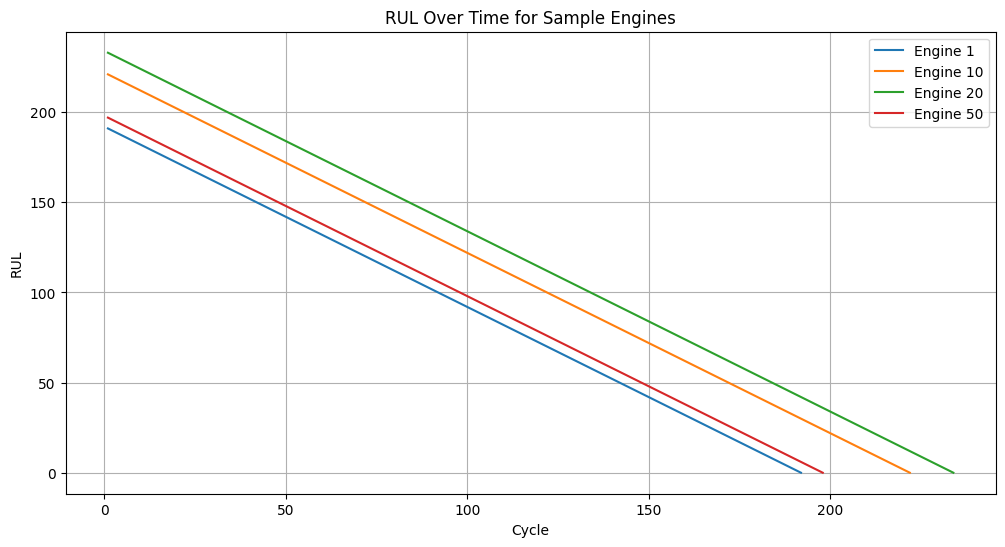

In [3]:
#A. Plot RUL over time for 4 engines

# Plot RUL over time for a few engines
sample_engines = [1, 10, 20, 50]

plt.figure(figsize=(12, 6))
for uid in sample_engines:
    subset = train_df[train_df['unit_number'] == uid]
    plt.plot(subset['time_in_cycles'], subset['RUL'], label=f'Engine {uid}')
plt.title("RUL Over Time for Sample Engines")
plt.xlabel("Cycle")
plt.ylabel("RUL")
plt.legend()
plt.grid(True)
plt.show()

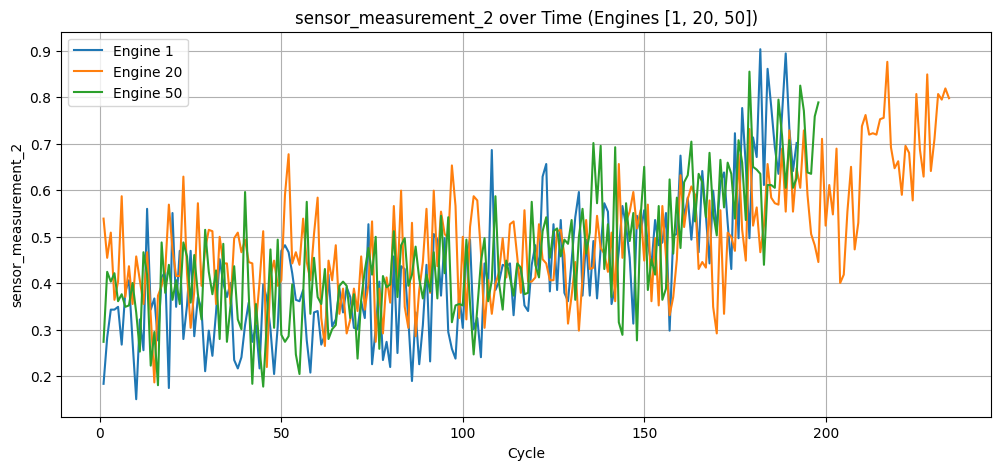

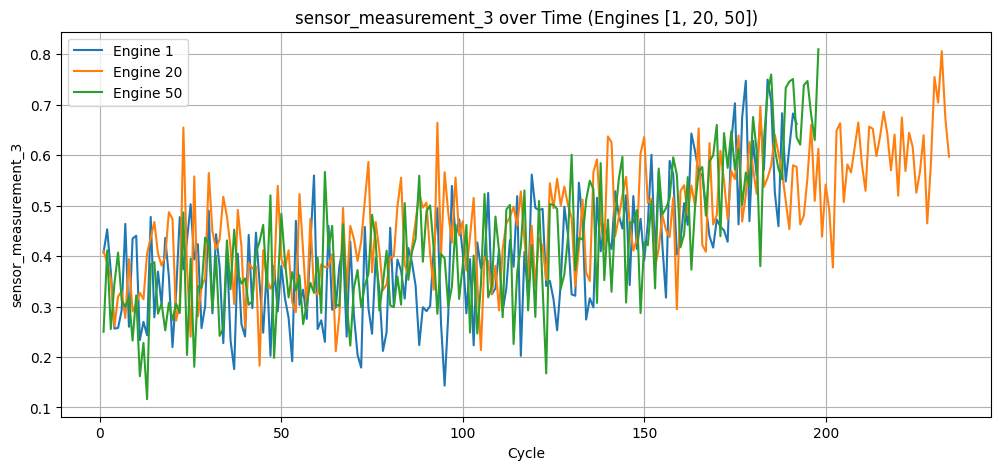

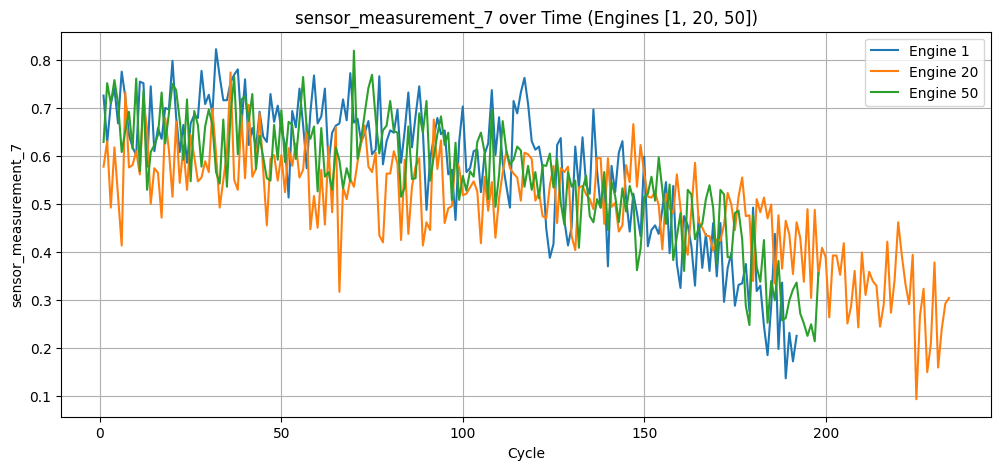

In [5]:
#Visualize sensor trends for degradation (4)

# Choose sensors likely to show degradation trends
selected_sensors = ['sensor_measurement_2', 'sensor_measurement_3', 'sensor_measurement_7']
engine_ids = [1, 20, 50]

for sensor in selected_sensors:
    plt.figure(figsize=(12, 5))
    for uid in engine_ids:
        subset = train_df[train_df['unit_number'] == uid]
        plt.plot(subset['time_in_cycles'], subset[sensor], label=f'Engine {uid}')
    plt.title(f"{sensor} over Time (Engines {engine_ids})")
    plt.xlabel("Cycle")
    plt.ylabel(sensor)
    plt.legend()
    plt.grid(True)
    plt.show()

In [7]:
#Identify flat (uninformative) sensors

# Standard deviation of each sensor (low = flat)
sensor_cols = [col for col in train_df.columns if 'sensor_measurement' in col]
std_values = train_df[sensor_cols].std().sort_values()

# Display flat sensors (std close to 0)
print("Sensors with low variance (possibly uninformative):")
print(std_values[std_values < 0.01])

Sensors with low variance (possibly uninformative):
sensor_measurement_1     0.0
sensor_measurement_19    0.0
sensor_measurement_18    0.0
sensor_measurement_5     0.0
sensor_measurement_10    0.0
sensor_measurement_16    0.0
dtype: float64


In [ ]:
These sensors can be dropped later bacause they are not working 

In [9]:
import pandas as pd
import numpy as np
from scipy.stats import zscore

# --- CONFIG ---
column_names = ['unit_number', 'time_in_cycles'] + \
               [f'op_setting_{i}' for i in range(1, 4)] + \
               [f'sensor_measurement_{i}' for i in range(1, 22)]

datasets = ['FD001', 'FD002', 'FD003', 'FD004']

# --- ANALYSIS FUNCTION ---
def analyze_dataset(df, name):
    print(f"\n======  EDA Report: {name} ======")
    print(f" Shape: {df.shape}")

    # Missing values
    missing = df.isnull().sum().sum()
    print(f" Missing values: {missing}")

    # Duplicates
    duplicates = df.duplicated().sum()
    print(f" Duplicate rows: {duplicates}")

    # Flat features (std ≈ 0)
    flat_features = df.loc[:, df.std() < 1e-4].columns.tolist()
    print(f" Flat (low-variance) features: {flat_features if flat_features else 'None'}")

    # Outliers (z-score > 3)
    numeric_cols = df.select_dtypes(include=np.number).columns
    z_scores = np.abs(zscore(df[numeric_cols]))
    outlier_counts = (z_scores > 3).sum(axis=0)
    top_outliers = outlier_counts[outlier_counts > 0].sort_values(ascending=False)

    print(" Outliers per column (count > 3σ):")
    if top_outliers.empty:
        print("None")
    else:
        print(top_outliers)

# --- MAIN LOOP ---
for fd in datasets:
    try:
        df = pd.read_csv(f'train_{fd}.txt', sep=' ', header=None)
        df.drop(columns=df.columns[df.isna().all()], inplace=True)
        df.columns = column_names
        analyze_dataset(df, f'train_{fd}')
    except Exception as e:
        print(f" Could not process {fd}: {e}")


======  EDA Report: train_FD001 ======
 Shape: (20631, 26)
 Missing values: 0
 Duplicate rows: 0
 Flat (low-variance) features: ['op_setting_3', 'sensor_measurement_1', 'sensor_measurement_5', 'sensor_measurement_10', 'sensor_measurement_16', 'sensor_measurement_18', 'sensor_measurement_19']
 Outliers per column (count > 3σ):
sensor_measurement_9     521
sensor_measurement_14    496
sensor_measurement_6     406
sensor_measurement_8     107
time_in_cycles            94
sensor_measurement_13     83
sensor_measurement_17     81
op_setting_1              53
sensor_measurement_3      47
sensor_measurement_20     43
sensor_measurement_4      36
sensor_measurement_7      34
sensor_measurement_12     34
sensor_measurement_21     34
sensor_measurement_15     33
sensor_measurement_2      31
sensor_measurement_11     23
dtype: int64

======  EDA Report: train_FD002 ======
 Shape: (53759, 26)
 Missing values: 0
 Duplicate rows: 0
 Flat (low-variance) features: None
 Outliers per column (count > 3

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Heatmap plot function
def plot_corr_heatmap(df, title=''):
    numeric_df = df.select_dtypes(include=np.number)
    corr_matrix = numeric_df.corr()

    plt.figure(figsize=(14, 10))
    sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt=".2f", linewidths=0.5)
    plt.title(f'🔗 Correlation Heatmap - {title}')
    plt.show()

# Print top correlated features with RUL
def print_top_corr_with_rul(df, name, top_n=5):
    corr = df.corr()['RUL'].drop('RUL')
    top_positive = corr.sort_values(ascending=False).head(top_n)
    top_negative = corr.sort_values().head(top_n)

    print(f"\n{name} -  Top + Correlated Sensors with RUL:\n", top_positive)
    print(f"\n{name} -  Top - Correlated Sensors with RUL:\n", top_negative)


🔍 Analyzing FD001...


C:\Users\jebus\anaconda3\envs\ml_gpu_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


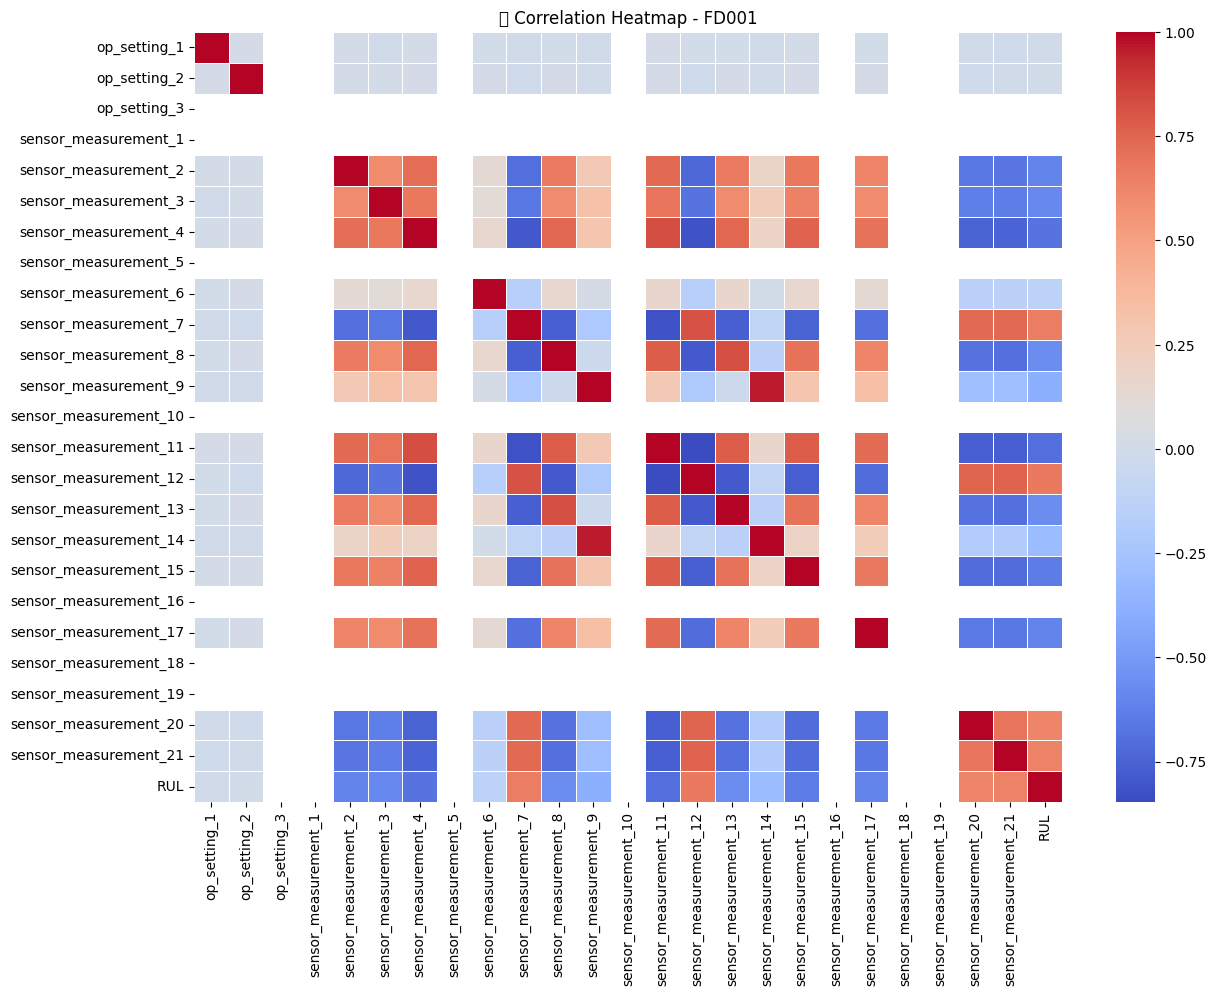


FD001 - 📈 Top + Correlated Sensors with RUL:
 sensor_measurement_12    0.671983
sensor_measurement_7     0.657223
sensor_measurement_21    0.635662
sensor_measurement_20    0.629428
op_setting_2            -0.001948
Name: RUL, dtype: float64

FD001 - 📉 Top - Correlated Sensors with RUL:
 sensor_measurement_11   -0.696228
sensor_measurement_4    -0.678948
sensor_measurement_15   -0.642667
sensor_measurement_2    -0.606484
sensor_measurement_17   -0.606154
Name: RUL, dtype: float64

🔍 Analyzing FD002...


C:\Users\jebus\anaconda3\envs\ml_gpu_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


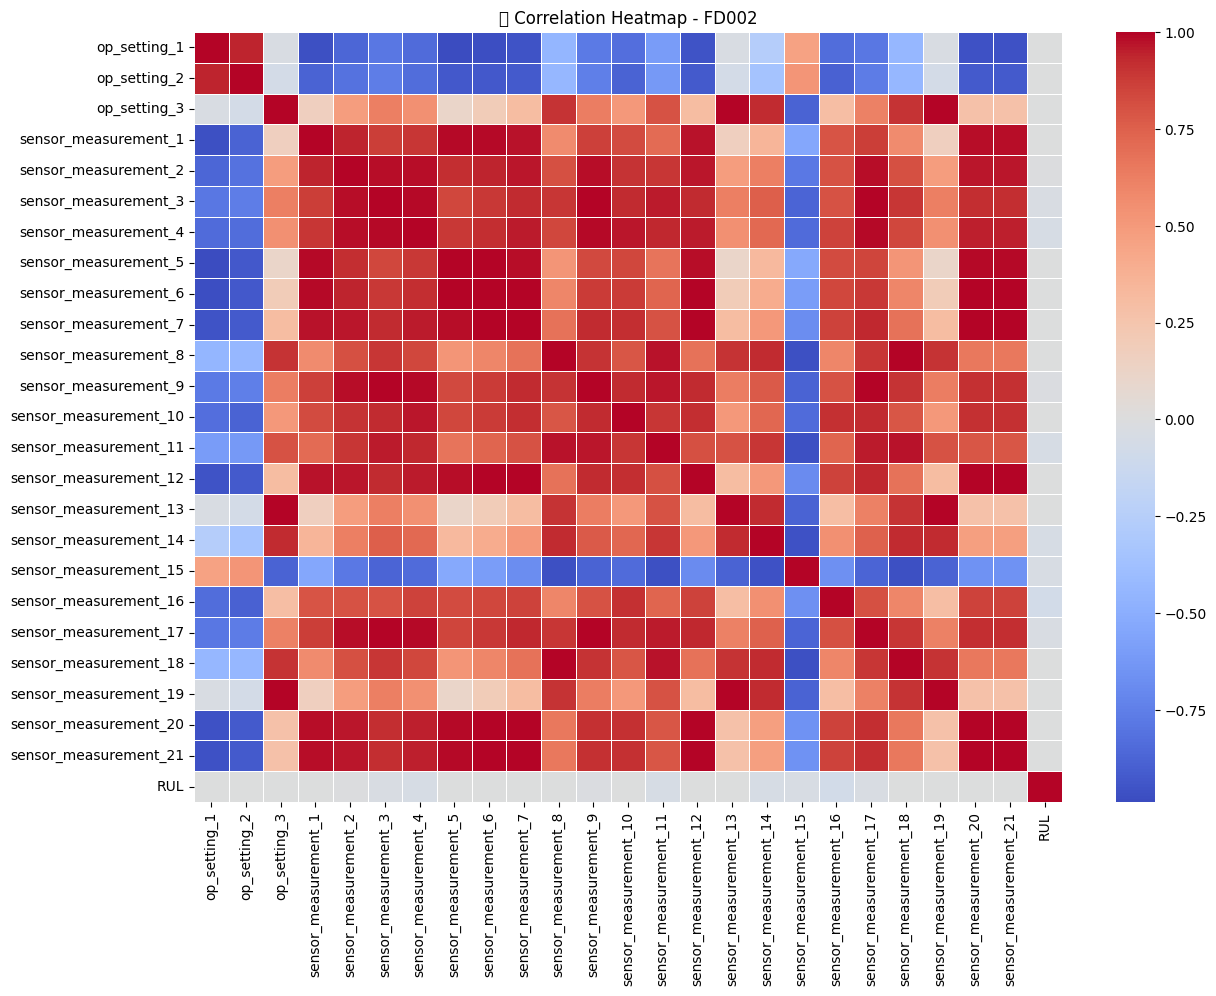


FD002 - 📈 Top + Correlated Sensors with RUL:
 sensor_measurement_20    0.006287
sensor_measurement_21    0.006165
sensor_measurement_19    0.005761
op_setting_3             0.005761
sensor_measurement_13    0.005245
Name: RUL, dtype: float64

FD002 - 📉 Top - Correlated Sensors with RUL:
 sensor_measurement_16   -0.071352
sensor_measurement_11   -0.046950
sensor_measurement_14   -0.042325
sensor_measurement_4    -0.040978
sensor_measurement_15   -0.038455
Name: RUL, dtype: float64

🔍 Analyzing FD003...


C:\Users\jebus\anaconda3\envs\ml_gpu_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


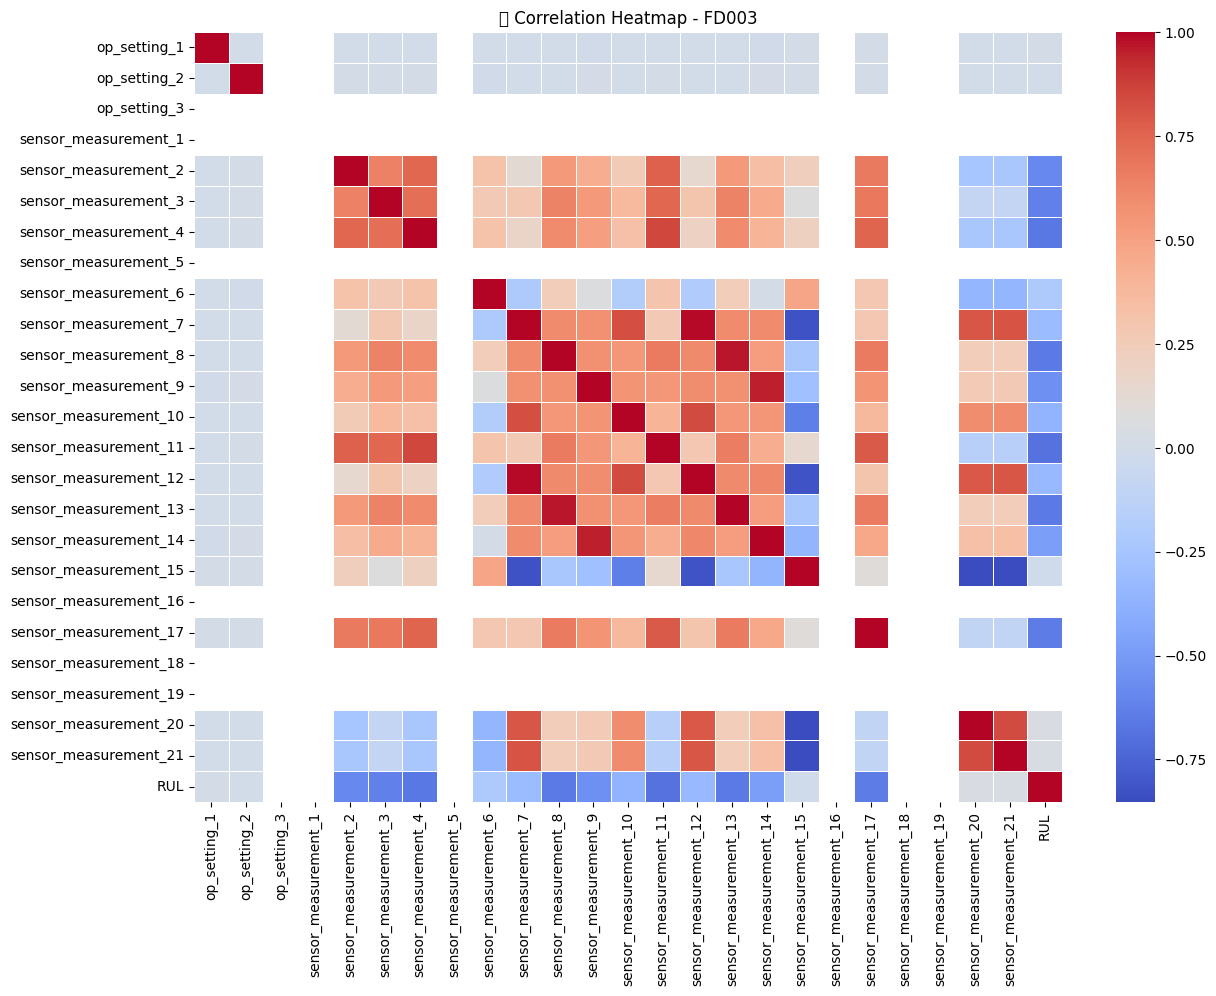


FD003 - 📈 Top + Correlated Sensors with RUL:
 sensor_measurement_20    0.037782
sensor_measurement_21    0.033465
op_setting_1             0.003700
op_setting_2            -0.001204
sensor_measurement_15   -0.016501
Name: RUL, dtype: float64

FD003 - 📉 Top - Correlated Sensors with RUL:
 sensor_measurement_11   -0.688915
sensor_measurement_4    -0.657224
sensor_measurement_13   -0.656340
sensor_measurement_8    -0.655345
sensor_measurement_17   -0.649220
Name: RUL, dtype: float64

🔍 Analyzing FD004...


C:\Users\jebus\anaconda3\envs\ml_gpu_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


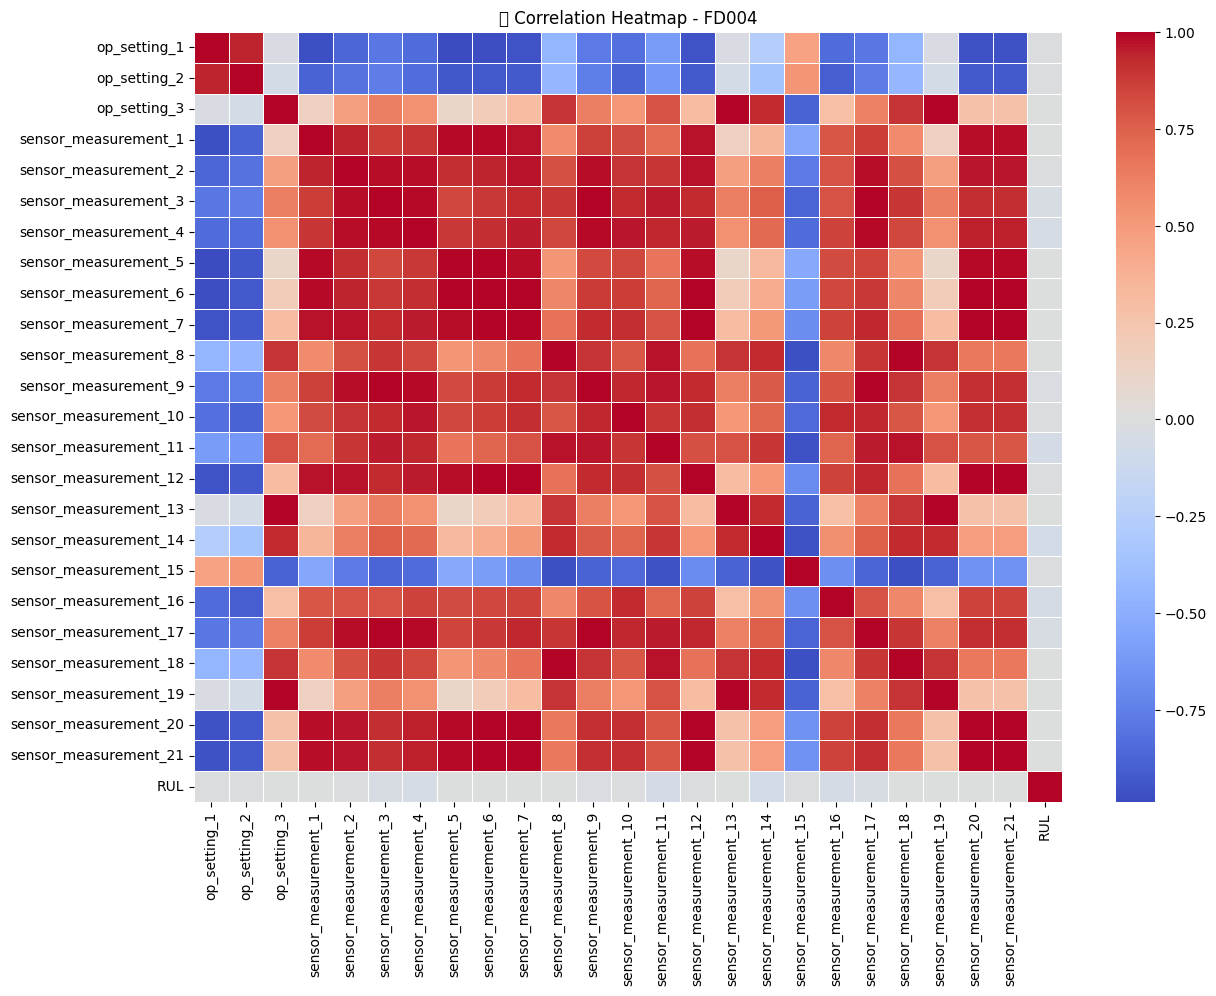


FD004 - 📈 Top + Correlated Sensors with RUL:
 sensor_measurement_20    0.002812
sensor_measurement_21    0.002791
sensor_measurement_18    0.002765
op_setting_3             0.002303
sensor_measurement_19    0.002303
Name: RUL, dtype: float64

FD004 - 📉 Top - Correlated Sensors with RUL:
 sensor_measurement_14   -0.078126
sensor_measurement_11   -0.056639
sensor_measurement_16   -0.053804
sensor_measurement_4    -0.045881
sensor_measurement_17   -0.032939
Name: RUL, dtype: float64


In [17]:
datasets = ['FD001', 'FD002', 'FD003', 'FD004']
column_names = ['unit_number', 'time_in_cycles'] + \
               [f'op_setting_{i}' for i in range(1, 4)] + \
               [f'sensor_measurement_{i}' for i in range(1, 22)]

for fd in datasets:
    try:
        df = pd.read_csv(f'train_{fd}.txt', sep=' ', header=None)
        df.drop(columns=df.columns[df.isna().all()], inplace=True)
        df.columns = column_names
        df['RUL'] = df.groupby('unit_number')['time_in_cycles'].transform('max') - df['time_in_cycles']
        
        print(f"\n Analyzing {fd}...")
        plot_corr_heatmap(df.drop(columns=['unit_number', 'time_in_cycles']), f'{fd}')
        print_top_corr_with_rul(df.drop(columns=['unit_number', 'time_in_cycles']), fd)
        
    except Exception as e:
        print(f" Error in {fd}: {e}")